참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 12.6 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=e468371c7426a860055bb1ad3e94d355d066c27868be00378b2d7e962ccbf5e2
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1264k      0  0:00:01  0:00:01 --:--:-- 1264k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exa

In [ ]:
import re
import urllib.request
from collections import Counter
from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [ ]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [ ]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [ ]:
train_data['label'].value_counts()

,count
label,
1,80003
0,79923


### 데이터 정제 및 전처리

In [ ]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

/tmp/ipython-input-39-64233451.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)
/tmp/ipython-input-39-64233451.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

### 토큰화

In [ ]:
#형태소 분석 모델 mecab 개체 만들기
mecab = Mecab()

#불용어 리스트 형태로 읽어오기
with open('drive/MyDrive/stopword.txt') as f:
	list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
	stopwords = re.sub('[\n]', '', stopword)
	stopwords_list.append(stopwords)

#train data 토큰화
#tokenized 라는 column 새로 만들어서 리뷰별로 형태소 저장
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
#형태소들 중에 불용어가 아닌 것만 리스트로 다시 저장
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

#test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [ ]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values #데이터프레임 값들만 갖고오기
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
X_train

array([list(['바디', '버든', '줄이', '려고', '써', '보', '려고', '샀', '는데', '음용', '할', '수', '잇', '는', '물', '헹궈야', '되', '면', '식기세척기', '쓰', '나요', '?']),
       list(['시중', '판매', '는', '건', '새', '우랑', '다르', '게', '속살', '고루', '분포', '된', '게', '라', '속', '비', '보이', '고', '속살', '한쪽', '뭉쳐', '?', '있', '어서', '씹', '딱딱', '합니다', '믿', '고', '먹', '어도', '되', '의심', '드', '네요']),
       list(['깔끔', '니', '이쁘', '네요', '좋']), ...,
       list(['100', '장', '주문', '안', '됩니다', '500', '장', '가능']),
       list(['.', '하림', '치킨', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '도', '쾅', '꽝', '얼', '어서', '도착', '고', '아주', '만족', '합니다', '!', 'ㅋㅋ']),
       list(['약해', '보이', '는데', '저렴', '게', '잘', '삿', '어요'])], dtype=object)

In [ ]:
print(type(X_train[0]))  # <class 'str'> 이어야 함!

<class 'list'>


In [ ]:
X_train = [' '.join(words) for words in X_train]

In [ ]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #내부에서 각문장을 lower로 바꾸려고 함. X_train이 List여야함

# vocab_size 설정 위해서 확인
vocab_size = len(tokenizer.word_index) #42435
vocab_size

42435

In [ ]:
#훈련에 없었으면 OOV 처리
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train) #단어장 만들기

#train, test 둘다 매핑(텍스트 -> 정수시퀀스)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 86
리뷰의 평균 길이 : 15.871659392469017


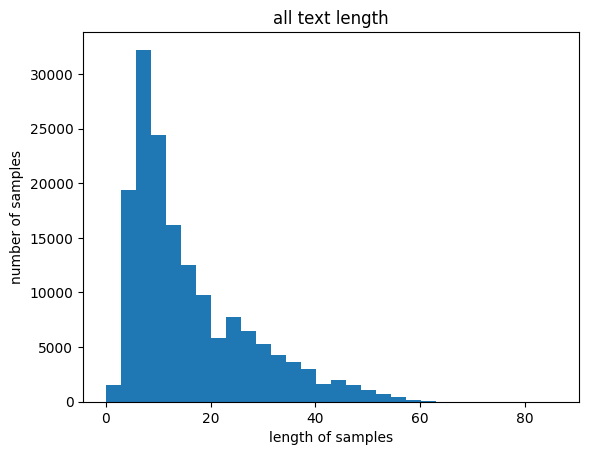

In [ ]:
num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.952728136763253


In [ ]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 퀴즈

문제: 패딩을 하는 이유는 무엇일까요? (어떤 경우에 사용하는지 생각해보세요)

답변: RNN, LSTM 같은 시퀀스 모델을 사용할 때 batch 형태로 데이터를 학습시키는데, 이때 길이가 서로 다르면 batch만들기가 어렵다. 즉, 패딩은 원활한 병렬연산을 위해 필요하다.

In [ ]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data #데이터셋
        self.labels = numpy_labels #정답 라벨
        self.transform = transform #데이터 전처리를위한 함수 들어올 수 있음

    def __len__(self): #데이터셋 길이(샘플 개수)
        return len(self.data)

    def __getitem__(self, index):
    #인덱스 i번째 데이터를 꺼내고, 필요하면 transform 적용해서 반환
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [ ]:
class RNNModel(nn.Module): #신경망 모델 정의할때 쓰는 기본 틀

		#모델 초기화시 필요한 여러 파라미터 받아오기
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__() #부모 클래스(nn.Module)의 초기화 함수 호출
        #이걸 해야 PyTorch가 이 모델 내부의 layer들을 인식하고 학습 가능해짐

        self.device = device #GPU , CPU, ...
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

				#정수 시퀀스 -> 임베딩 벡터로 변환
				#vocab_size 만큼 행이 있고, 각 행은 크기 embedding_dim인 벡터
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

				#모델 생성
				#input_size = embedding_dim
				#batch_first=True → input shape 형식 명시
				#여러  층일때 층 사이에 droppout 적용
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim,
            batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        # hidden_dim -> out이 (batch_size, hidden_dim)이니까 이걸 변환하기위해.
        self.fc = nn.Linear(hidden_dim, output_dim)

		#text: 정수 시퀀스로 된 입력 텐서. shape: (batch_size, seq_len)
    def forward(self, text):
        embedded = self.embedding(text) #정수 시퀀스 -> 임베딩 벡터

				#초기 hidden state 0으로 초기화시키기
				#shape : (num_layers, batch_size, hidden_dim) 맞춰서.
				#requires_grad_() : autograd 추적 가능하도록 (뒤에서 backprop 할 수 있게)
        h0 = torch.zeros(self.layer_dim, text.size(0),
								        self.hidden_dim).requires_grad_()

        h0 = h0.to(self.device)

        #embedded: (batch_size, seq_len, embedding_dim)
        out, h0 = self.rnn(embedded, h0.detach()) #실제 RNN 수행
        #결과 out: 모든 time step의 hidden state
        #결과 h0: 마지막 time step의 hidden state 됨

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        # 즉 마지막 time step의 출력만 가져오기
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.

        out: (batch_size, hidden_dim) -> fc거쳐서 (hidden_dim, output_dim)
        """
        out = self.fc(out)
        return out #모델 예측결과

In [ ]:
num_epoch = 8 #epoch 줄이기
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 2 #2개로 설정
output_dim = 4

#실제 실행. 0.5는 dropout_prob.
model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.3, device) #dropout 비율 조정
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요

softmax로 계산해야 하므로 nn.CrossEntropyLoss() 활용
"""
criterion = nn.CrossEntropyLoss()

In [ ]:
iter = 0 #500번마다 확인용
for epoch in range(num_epoch): #에폭마다
    for i, (text, labels) in enumerate(train_dataloader): #한 batch씩 텍스트랑 정답 꺼내기
        model.train() #학습모드
        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #gradient 초기화

        logits = model(text).to(device) #text 입력받아서 logits 출력


        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.

        loss 함수로 앞서 정의했던 criterion 적용
        """
        loss = criterion(logits, labels)

        loss.backward() #역전파

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.

        optimizer.step() : 내부적으로 .parameters()로 모델의 weight들을 보고
        거기에 저장된 .grad를 바탕으로 파라미터를 업데이트하는 함수
        """
        optimizer.step()

        iter += 1

				# 500번째 마다 test 정확도 출력
        if iter % 500 == 0:
            model.eval()   #평가 모드
            correct = 0
            total = 0

            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)

                outputs = model(test_text) #예측결과 (logits)

                # Get predictions from the maximum value
                #outputs.data: softmax 통과 전 값
								#dim=1: 클래스 차원에서 최대값 선택
                _, predicted = torch.max(outputs.data, 1) #예측결과중 확률이 가장 큰클래스 선택

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.44138234853744507. Accuracy: 83.52508544921875
Iteration: 1000. Loss: 0.3247619867324829. Accuracy: 85.94367218017578
Iteration: 1500. Loss: 0.4661957323551178. Accuracy: 87.8895492553711
Iteration: 2000. Loss: 0.3642940819263458. Accuracy: 87.37181854248047
Iteration: 2500. Loss: 0.18125110864639282. Accuracy: 87.79701232910156
Iteration: 3000. Loss: 0.24877142906188965. Accuracy: 87.59691619873047
Iteration: 3500. Loss: 0.210923969745636. Accuracy: 88.54484558105469
Iteration: 4000. Loss: 0.19076460599899292. Accuracy: 88.85748291015625
Iteration: 4500. Loss: 0.31540152430534363. Accuracy: 87.91456604003906
Iteration: 5000. Loss: 0.21657167375087738. Accuracy: 88.03461456298828
Iteration: 5500. Loss: 0.2671690285205841. Accuracy: 87.67195129394531
Iteration: 6000. Loss: 0.30817681550979614. Accuracy: 84.222900390625
Iteration: 6500. Loss: 0.21085768938064575. Accuracy: 87.96458435058594
Iteration: 7000. Loss: 0.34906476736068726. Accuracy: 87.5869140625
Iterat

### 모델학습 (LSTM, Long short term memory)

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer #hidden_dim으로 수정
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

				# 초기 상태 설정: LSTM은 h0 뿐만 아니라 c0도 필요!
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [ ]:
num_epoch = 8
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 2 #2개로 높여봄
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.3, device) #0.3으로 dropout 비율 조정
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [ ]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.05966214835643768. Accuracy: 90.59326934814453
Iteration: 2000. Loss: 0.16082094609737396. Accuracy: 91.03846740722656
Iteration: 3000. Loss: 0.16553480923175812. Accuracy: 91.26856994628906
Iteration: 4000. Loss: 0.23509874939918518. Accuracy: 91.2310562133789
Iteration: 5000. Loss: 0.2690355181694031. Accuracy: 91.5386962890625
Iteration: 6000. Loss: 0.07858341187238693. Accuracy: 90.97843933105469
Iteration: 7000. Loss: 0.15160827338695526. Accuracy: 91.37361907958984
Iteration: 8000. Loss: 0.1489710956811905. Accuracy: 91.09849548339844
Iteration: 9000. Loss: 0.15046817064285278. Accuracy: 91.19853973388672
Iteration: 10000. Loss: 0.05992027372121811. Accuracy: 91.1460189819336
Iteration: 11000. Loss: 0.21013891696929932. Accuracy: 90.97093963623047
Iteration: 12000. Loss: 0.09168926626443863. Accuracy: 90.62328338623047
Iteration: 13000. Loss: 0.03871922194957733. Accuracy: 90.41568756103516
Iteration: 14000. Loss: 0.04510849714279175. Accuracy: 90.8808975

### 모델 학습 (Gated Recurrent Unit (GRU))

In [ ]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU( #dropout 굳이 설정 x
            embedding_dim, hidden_dim, layer_dim, batch_first=True
        )

        # Fully connected layer #hidden_dim으로 수정
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [ ]:
num_epoch =7 #epoch을 오히려 줄이기
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [ ]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.23318490386009216. Accuracy: 89.43024444580078
Iteration: 2000. Loss: 0.26374173164367676. Accuracy: 90.92842102050781
Iteration: 3000. Loss: 0.227187842130661. Accuracy: 91.05097198486328
Iteration: 4000. Loss: 0.17651721835136414. Accuracy: 91.1410140991211
Iteration: 5000. Loss: 0.21139702200889587. Accuracy: 91.33360290527344
Iteration: 6000. Loss: 0.14131487905979156. Accuracy: 90.7933578491211
Iteration: 7000. Loss: 0.22868947684764862. Accuracy: 90.74333190917969
Iteration: 8000. Loss: 0.17635859549045563. Accuracy: 90.7158203125
Iteration: 9000. Loss: 0.1318039745092392. Accuracy: 90.96843719482422
Iteration: 10000. Loss: 0.12340687960386276. Accuracy: 89.90545654296875
Iteration: 11000. Loss: 0.15586070716381073. Accuracy: 90.3281478881836
Iteration: 12000. Loss: 0.1863301396369934. Accuracy: 90.24311065673828
Iteration: 13000. Loss: 0.08747770637273788. Accuracy: 89.66535186767578
Iteration: 14000. Loss: 0.20622538030147552. Accuracy: 90.2506103515625

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!


공통적으로 epoch이 많다고 해서 학습이 더 잘되는 건 아닌 것 같고 과적합 위헙도 있어서, 절반으로 줄였고 그 결과 성능이 개선되었다. epoch을 줄였고, dropout 비율을 조정하거나 layer 수를 늘리거나, dropout을 굳이 설정하지 않는 방식으로 진행했을 때 성능이 개선되었다. RNN은 정확도의 변화가 안정적이지 않았고 성능도 현저히 떨어졌지만 LSTM과 GRU는 비교적 안정적이었고 성능도 더 좋게 나왔다.

* out 차원도 모두 잘못설정되어있어서 embedding_size는 hidden_dim으로 수정했다